<div >
<img src = "figs/ans_banner_1920x200.png" />
</div>

## Desarrollo


### 1.Carga de datos

In [2]:
# Utilice este espacio para escribir el código.
import gower
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from scipy.spatial import distance_matrix
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn import cluster
np.set_printoptions(precision=2)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import DBSCAN
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [8]:
# Cargar datos desde el archivo CSV
archivo = 'data/ACCIDENTES_VF.xlsx'
data_orig = pd.read_excel(archivo)

# Quedarnos solo con las columnas que tienen que ver con la gravedad del accidente o una caracterizacion de este.
data = data_orig[['GravedadNombre', 'Tipo_Accidente', 'Choque_Nombre',
       'Latitud', 'Longitud', 'HoraOcurrencia', 'TipoVia', 'CON_BICICLETA',
       'CON_CARGA', 'CON_EMBRIAGUEZ', 'CON_HUECOS', 'CON_MENORES', 'CON_MOTO',
       'CON_PEATON', 'CON_PERSONA_MAYOR', 'CON_RUTAS', 'CON_TPI',
       'CON_VELOCIDAD', 'TOTAL_VICTIMAS', 'CantidadVictimasPeatones',
       'CantidadVictimasAcompanante', 'CantidadVictimasPasajeros',
       'TOTAL_CONDUCTORES', 'CantidadConductoresMotocicleta',
       'CantidadConductoresBICICLETA', 'CantidadConductoresLivianos',
       'CantidadConductoresPesados', 'CantidadConductoresHombres',
       'CantidadConductoresMujeres', 'ModeloVehiculo']]


columnas_num = data.select_dtypes(include=['number'])
columnas_cat = data.select_dtypes(include=['object'])

# Codificación de variables categóricas
data = pd.get_dummies(data, columns=list(columnas_cat.columns), drop_first=True).astype(int)

# Escalado de variables numéricas
scaler = StandardScaler()
cols = data.columns
data = scaler.fit_transform(data)


pca = PCA(n_components=0.90)
reduced_data = pca.fit_transform(data)

# Número de componentes seleccionados
n_components = pca.n_components_

print(f"Número de componentes seleccionados: {n_components}")
print(f"Varianza explicada por los componentes seleccionados: {pca.explained_variance_ratio_.sum()}")

data

Número de componentes seleccionados: 1285
Varianza explicada por los componentes seleccionados: 0.9005342772099992


array([[ 0.  ,  0.  ,  0.86, ..., -0.02, -0.48, -0.09],
       [ 0.  ,  0.  , -0.32, ..., -0.02, -0.48, -0.09],
       [ 0.  ,  0.  , -0.32, ..., -0.02, -0.48, -0.09],
       ...,
       [ 0.  ,  0.  , -0.32, ..., -0.02, -0.48, -0.09],
       [ 0.  ,  0.  , -0.32, ..., -0.02, -0.48, -0.09],
       [ 0.  ,  0.  ,  0.86, ..., -0.02, -0.48, -0.09]])

### 4. DBSCAN

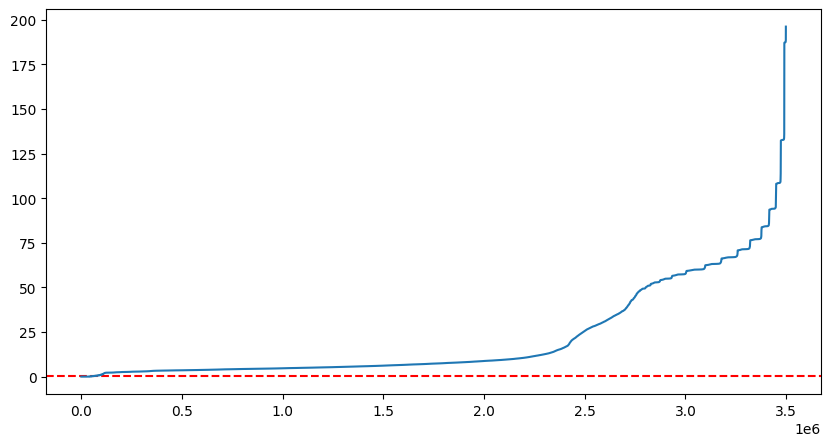

In [34]:
# Cargamos NeighborsNeighbors
from sklearn.neighbors import NearestNeighbors

data_matrix = data

neigh = NearestNeighbors(n_neighbors = 150)
nbrs = neigh.fit(data_matrix)
distancias, indices = nbrs.kneighbors(data_matrix)
distancias = np.sort(distancias.flatten())
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.axhline(y = 0.49, color = 'r', linestyle = '--')
plt.plot(distancias)

In [35]:
from kneed import KneeLocator

i = np.arange(len(distancias))
knee = KneeLocator(i, distancias, S=1, curve='convex', direction='increasing', interp_method='polynomial')

distancias[knee.knee]

10.229835279362275

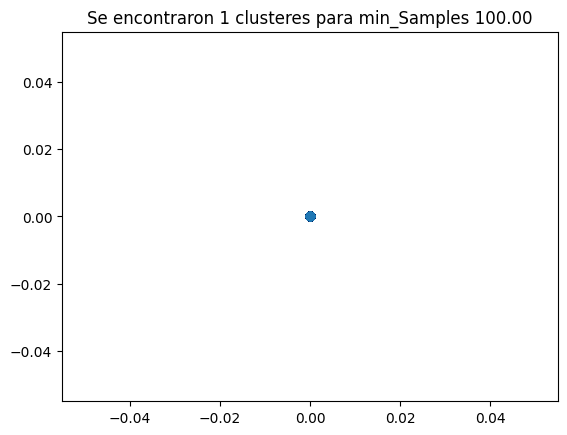

In [29]:
for minpts in [100]:
    db = DBSCAN(eps =distancias[knee.knee], min_samples = minpts).fit(data_matrix)
    clusteres = db.labels_
    n_clusteres = len(set(clusteres)) - (1 if -1 in clusteres else 0)
    resultado = pd.DataFrame(data_matrix).assign(Cluster = clusteres)
    plt.figure()
    for k in np.unique(clusteres):
        if k != -1:
            plt.scatter(
                x = resultado.loc[resultado.Cluster == k, 0],
                y = resultado.loc[resultado.Cluster == k, 1]
                )
        else:
            plt.scatter(
                x = resultado.loc[resultado.Cluster == k, 0],
                y = resultado.loc[resultado.Cluster == k, 1],
                c = "black"
                )
    plt.title('Se encontraron %d clusteres para min_Samples %0.2f' % (n_clusteres, minpts))


In [44]:
# Crear un objeto DBSCAN con los parámetros elegidos
dbscan = DBSCAN(eps=60, min_samples=3, metric='euclidean')

# Ajustar el modelo a los datos
dbscan.fit(data_matrix)

# Obtener los labels de los clusters
clusters = dbscan.labels_

# Agregar los resultados de los clusters al DataFrame
data_orig['DBSCAN_Cluster'] = clusters

In [45]:
data_orig['DBSCAN_Cluster'].value_counts()

DBSCAN_Cluster
 0      30734
-1        276
 399        9
 103        9
 431        9
        ...  
 521        3
 513        3
 510        3
 150        3
 646        3
Name: count, Length: 648, dtype: int64

In [49]:
# Obtiene la lista de valores únicos en la columna "Cluster"

cluster_type = 'DBSCAN_Cluster'

valores_unicos_cluster = [-1]

 

# Crea un diccionario para almacenar los resultados

resultados_describe = {}

 

# Itera a través de los valores únicos en la columna "Cluster"

for valor_cluster in valores_unicos_cluster:

    # Filtra el DataFrame para el valor de "Cluster" actual

    df_filtrado = data_orig[data_orig[cluster_type] == valor_cluster]

 

    # Aplica describe() al DataFrame filtrado y almacena los resultados en el diccionario

    resultados_describe[valor_cluster] = df_filtrado.drop(columns=[cluster_type]).describe(include='all')
, 
 

 # Puedes acceder a los resultados para cada valor de "Cluster" a través del diccionario

for valor_cluster, descripcion in resultados_describe.items():

    print(f"Resumen estadístico para Cluster {valor_cluster}:\n{descripcion}\n")

Resumen estadístico para Cluster -1:
        idFormulario GravedadNombre Tipo_Accidente Choque_Nombre     Latitud  \
count     276.000000            276            276           276  276.000000   
unique           NaN              3              5            17         NaN   
top              NaN     Solo Daños         Choque      Vehiculo         NaN   
freq             NaN            155            234           194         NaN   
mean    18660.739130            NaN            NaN           NaN    4.642081   
std     10370.651125            NaN            NaN           NaN    0.058885   
min       191.000000            NaN            NaN           NaN    4.484361   
25%      9691.250000            NaN            NaN           NaN    4.599351   
50%     18696.000000            NaN            NaN           NaN    4.636399   
75%     29087.500000            NaN            NaN           NaN    4.683488   
max     34980.000000            NaN            NaN           NaN    4.815158   

  

In [50]:
df_filtrado = data_orig[data_orig[cluster_type] == valor_cluster]

In [52]:
df_filtrado.columns

Index(['idFormulario', 'GravedadNombre', 'Tipo_Accidente', 'Choque_Nombre',
       'Latitud', 'Longitud', 'HoraOcurrencia', 'TipoVia', 'CON_BICICLETA',
       'CON_CARGA', 'CON_EMBRIAGUEZ', 'CON_HUECOS', 'CON_MENORES', 'CON_MOTO',
       'CON_PEATON', 'CON_PERSONA_MAYOR', 'CON_RUTAS', 'CON_TPI',
       'CON_VELOCIDAD', 'TOTAL_VICTIMAS', 'CantidadVictimasPeatones',
       'CantidadVictimasAcompanante', 'CantidadVictimasPasajeros',
       'TOTAL_CONDUCTORES', 'CantidadConductoresMotocicleta',
       'CantidadConductoresBICICLETA', 'CantidadConductoresLivianos',
       'CantidadConductoresPesados', 'CantidadConductoresHombres',
       'CantidadConductoresMujeres', 'ModeloVehiculo', 'DBSCAN_Cluster'],
      dtype='object')

c:\users\dhoyoso\appdata\local\programs\python\python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\users\dhoyoso\appdata\local\programs\python\python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\users\dhoyoso\appdata\local\programs\python\python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\users\dhoyoso\appdata\local\programs\python\python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na 

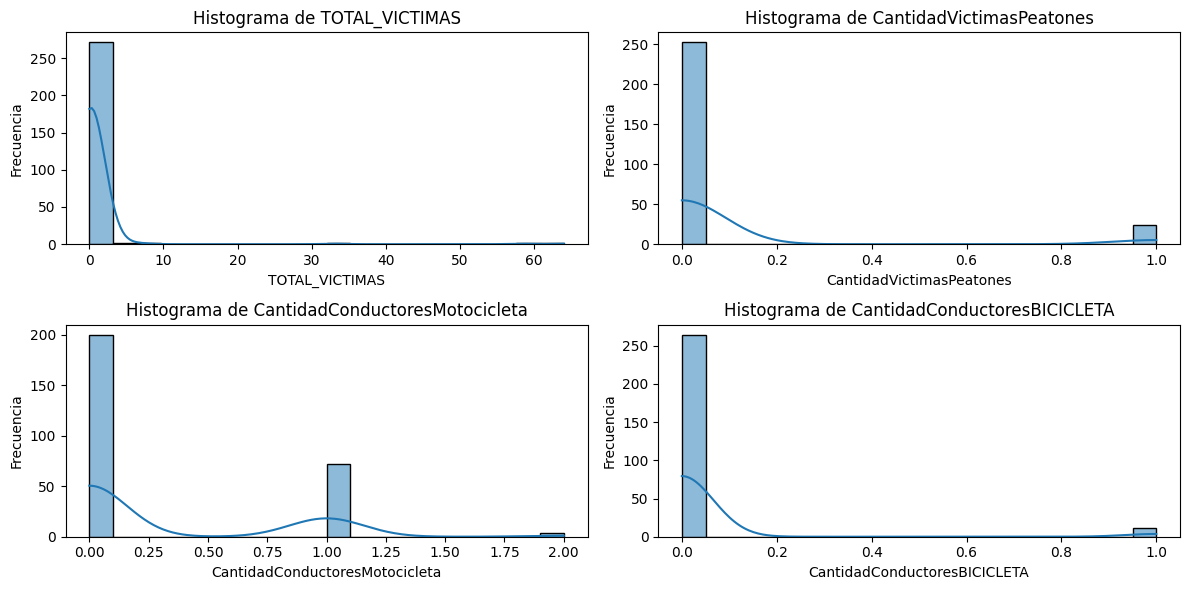

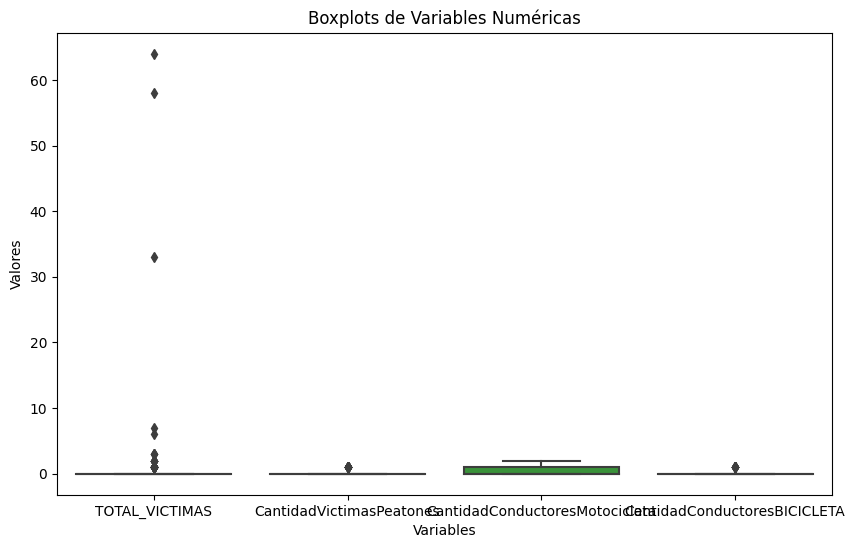

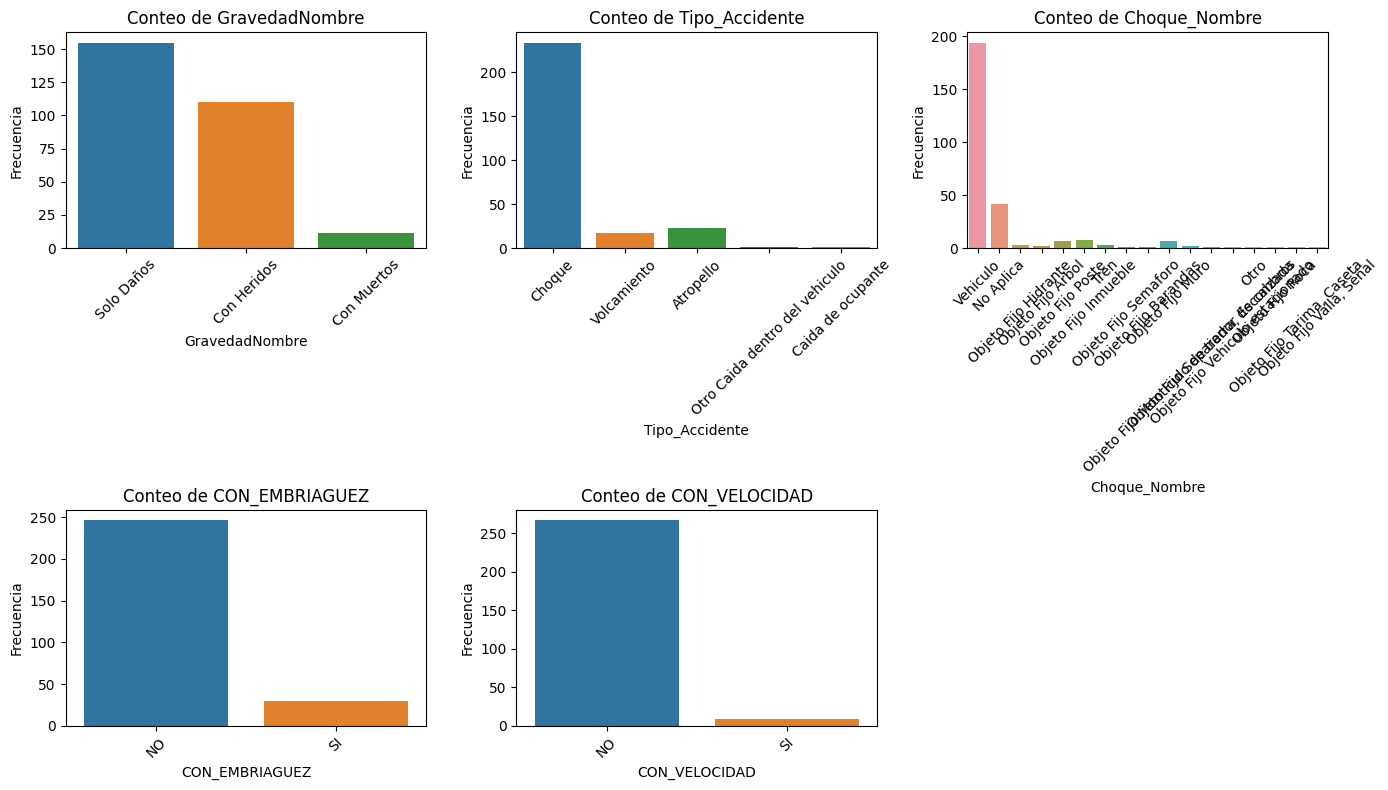

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el DataFrame con tus datos de accidentes
# Supongamos que se llama 'df_accidentes'
# df_accidentes = pd.read_csv('tu_archivo.csv')

df_accidentes=df_filtrado

# Resumen estadístico de las variables numéricas
resumen_estadistico = df_accidentes.describe()

# Histogramas de variables numéricas
variables_numericas = ['TOTAL_VICTIMAS', 'CantidadVictimasPeatones', 'CantidadConductoresMotocicleta', 'CantidadConductoresBICICLETA']

plt.figure(figsize=(12, 6))
for i, variable in enumerate(variables_numericas, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_accidentes[variable], bins=20, kde=True)
    plt.title(f'Histograma de {variable}')
    plt.xlabel(variable)
    plt.ylabel('Frecuencia')

plt.tight_layout()

# Boxplots de variables numéricas
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_accidentes[variables_numericas])
plt.title('Boxplots de Variables Numéricas')
plt.xlabel('Variables')
plt.ylabel('Valores')

# Gráficos de barras de variables categóricas
variables_categoricas = ['GravedadNombre', 'Tipo_Accidente', 'Choque_Nombre', 'CON_EMBRIAGUEZ', 'CON_VELOCIDAD']

plt.figure(figsize=(14, 8))
for i, variable in enumerate(variables_categoricas, 1):
    plt.subplot(2, 3, i)
    sns.countplot(data=df_accidentes, x=variable)
    plt.title(f'Conteo de {variable}')
    plt.xlabel(variable)
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45)

plt.tight_layout()

# Matriz de correlación (si es relevante)
matriz_correlacion = df_accidentes[variables_numericas].corr()

# Mostrar todas las visualizaciones
plt.show()

# Puedes realizar más análisis y visualizaciones específicas según tus necesidades
